# HW5 - Real Time Machine Learning
Jacob Barker
801075553

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from d2l import tensorflow as d2l
import time

Problem 1 (50pts)

For the problem of Machine Translation problem: Train a deeper Transformer than what we did during the lectures.  How does it affect the training speed, model complexity, and translation performance both quantitatively and qualitatively? Report and plot your results.

In [6]:
class TransformerDecoderBlock(tf.keras.layers.Layer):
    # The i-th block in the Transformer decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = d2l.AddNorm(norm_shape, dropout)

    def call(self, X, state, **kwargs):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = tf.concat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if kwargs["training"]:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = tf.repeat(
                tf.reshape(tf.range(1, num_steps + 1),
                           shape=(-1, num_steps)), repeats=batch_size, axis=0)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens,
                             **kwargs)
        Y = self.addnorm1(X, X2, **kwargs)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens,
                             **kwargs)
        Z = self.addnorm2(Y, Y2, **kwargs)
        return self.addnorm3(Z, self.ffn(Z), **kwargs), state


In [7]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = [TransformerDecoderBlock(
            key_size, query_size, value_size, num_hiddens, norm_shape,
            ffn_num_hiddens, num_heads, dropout, i)
                     for i in range(num_blks)]
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def call(self, X, state, **kwargs):
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(
            tf.cast(self.num_hiddens, dtype=tf.float32)), **kwargs)
        # 2 attention layers in decoder
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state, **kwargs)
            # Decoder self-attention weights
            self._attention_weights[0][i] = (
                blk.attention1.attention.attention_weights)
            # Encoder-decoder attention weights
            self._attention_weights[1][i] = (
                blk.attention2.attention.attention_weights)
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights


72.20477986335754


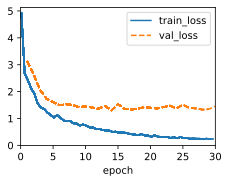

In [8]:
#Original Model from the lectures
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
key_size, query_size, value_size = 256, 256, 256
norm_shape = [2]
with d2l.try_gpu():
    encoder = d2l.TransformerEncoder(
        len(data.src_vocab), key_size, query_size, value_size, num_hiddens,
        norm_shape, ffn_num_hiddens, num_heads, num_blks, dropout)
    decoder = TransformerDecoder(
        len(data.tgt_vocab), key_size, query_size, value_size, num_hiddens,
        norm_shape, ffn_num_hiddens, num_heads, num_blks, dropout)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                        lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
temp = time.time()
trainer.fit(model, data)
print(time.time()-temp)

In [9]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['continuez', '.'], bleu,0.000
i lost . => ['je', 'suis', '<unk>', 'perdu', '.'], bleu,0.447
he's calm . => ['soyez', 'calme', '!'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'suis', 'chez', 'moi', 'chez', 'moi', 'chez'], bleu,0.522


97.4366660118103


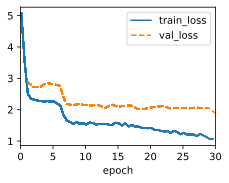

In [10]:
#My deeper transformer model for the machine translation
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 3, 0.2
ffn_num_hiddens, num_heads = 64, 4
key_size, query_size, value_size = 256, 256, 256
norm_shape = [2]
with d2l.try_gpu():
    encoder = d2l.TransformerEncoder(
        len(data.src_vocab), key_size, query_size, value_size, num_hiddens,
        norm_shape, ffn_num_hiddens, num_heads, num_blks, dropout)
    decoder = TransformerDecoder(
        len(data.tgt_vocab), key_size, query_size, value_size, num_hiddens,
        norm_shape, ffn_num_hiddens, num_heads, num_blks, dropout)
    model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                        lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
temp = time.time()
trainer.fit(model, data)
print(time.time()-temp)

In [11]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['<unk>', '!'], bleu,0.000
i lost . => ['je', 'je', 'je', 'je', 'je', 'je', 'je', 'je', 'je'], bleu,0.000
he's calm . => ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'], bleu,0.000
i'm home . => ['je', 'je', 'je', 'je', 'je', 'je', 'je', 'je', 'je'], bleu,0.000


Problem 2 (50pts)

For the problem of the Vision Transformer, we need, in lectures, to train a deeper Transformer with more multiheaded self-attention blocks.   How does it affect the training speed, model complexity, and validation accuracy? Report and plot your results.

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import time

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)


In [3]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))


In [4]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))


In [5]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])


349.3224310874939


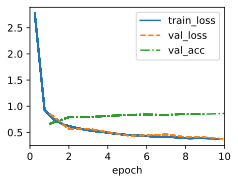

In [6]:
#Base model from the lectures
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
temp = time.time()
trainer.fit(model, data)
print(time.time()-temp)

517.7094645500183


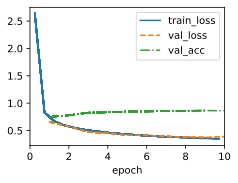

In [7]:
#ViT model with more multiheaded attention blocks from the lectures
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 3
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
temp = time.time()
trainer.fit(model, data)
print(time.time()-temp)